# Topic 3: Neural Networks, Convolutional Neural Networks (CNNs)
### In this notebook, we will use TensorFlow to design a convolutional neural network for image classification with the CIFAR-10 dataset.

In [1]:
# import some things we need
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Import the CIFAR-10 dataset directly from TensorFlow.
The dataset contains 60000 (50000 for training and 10000 for testing) images each with 32x32 pixels and 3 color channels (RGB).

There are 10 classes, which are:
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Data source:
@TECHREPORT{Krizhevsky09learningmultiple,
    author = {Alex Krizhevsky},
    title = {Learning multiple layers of features from tiny images},
    institution = {},
    year = {2009}
}

In [2]:
# This is needed for certain versions of Python
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    uhttpsc = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = uhttpsc

# download the CIFAR-10 dataset directly from TensorFlow
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

In [3]:
# Shape of training and testing sets
print("Training Images: ", X_train.shape)
print("Testing Images:  ", X_test.shape)
print("Training Labels: ", Y_train.shape)
print("Testing Labels:  ", Y_test.shape)

Training Images:  (50000, 32, 32, 3)
Testing Images:   (10000, 32, 32, 3)
Training Labels:  (50000, 1)
Testing Labels:   (10000, 1)


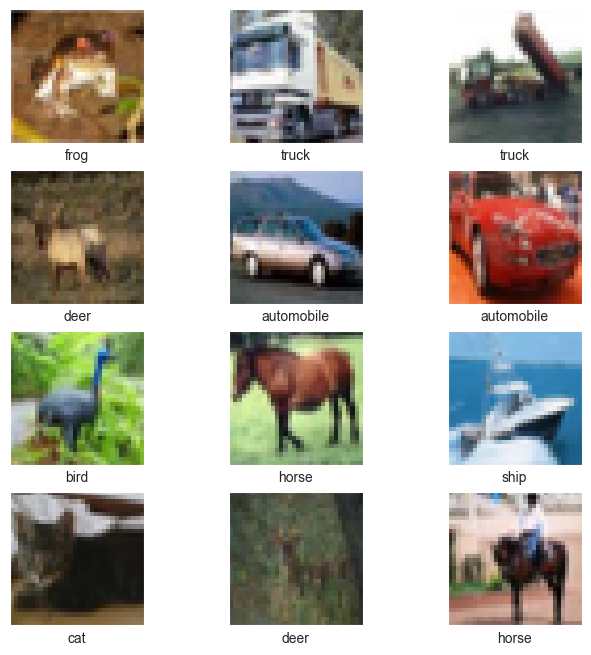

In [11]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Show some of the images
plt.figure(figsize=(8, 8), facecolor='white')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.imshow(X_train[i])
    plt.xticks(())
    plt.yticks(())
    plt.grid(False)
    plt.xlabel(class_labels[Y_train[i][0]])

## Building the CNN

We will use the Keras functional API in TensorFlow 2 to create a simple CNN

In [5]:
# this is the dropout rate used on the dropout layers
dropout_rate = 0.5
# Create the input layer, which for these images is 32x32 pixels with 3 color channels
inputs = keras.Input(shape=(32, 32, 3))
# Now let's create a convolutional layer with kernel of size 5x5, 20 filters, and a 2x1 stride, using the swish activation function
conv1 = keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding="valid", activation=keras.activations.swish)(inputs)
# Add a max-pooling layer to reduce dimensionality
maxpool1 = keras.layers.MaxPool2D(pool_size=(2, 2), padding="valid")(conv1)
# Dropout layer
dropout1 = keras.layers.Dropout(rate=dropout_rate)(maxpool1)
# Add another convolutional layer with 10 filters, a kernel size of 3x3, a stride of 1x1, and the swich activation function
conv2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation=keras.activations.swish)(dropout1)
# Add another max-pooling layer to reduce dimensionality
maxpool2 = keras.layers.MaxPool2D(pool_size=(2, 2), padding="valid")(conv2)
# Dropout layer
dropout2 = keras.layers.Dropout(rate=dropout_rate)(maxpool2)
# add one final convolutional layer with 2x2 kernel, 1x1 stride, 6 filters, and swish activation function
conv3 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation=keras.activations.swish)(dropout2)
# Now we will flatten the dimensionality of the output of the final convolutional layer
flattened = keras.layers.Flatten()(conv3)
# Dropout layer
dropout3 = keras.layers.Dropout(rate=dropout_rate)(flattened)
# Add a dense layer with 32 swish neurons
dense1 = keras.layers.Dense(units=48, activation=keras.activations.swish)(dropout3)
# Dropout layer
dropout4 = keras.layers.Dropout(rate=dropout_rate)(dense1)
# Add the final output layer with 10 (number of classes) softmax neurons
dense2 = keras.layers.Dense(units=10, activation=keras.activations.softmax)(dropout4)

# define the model
model = keras.Model(inputs=inputs, outputs=dense2, name="cifar10_CNN")

Metal device set to: Apple M1 Max


2022-10-23 22:57:38.020996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-23 22:57:38.021208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Show a summary of the model
model.summary()

Model: "cifar10_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                 

In [7]:
# Let's normalize the images
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Compile the model so that it is ready for training
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Nadam(),
    metrics=["accuracy"]
)

history = model.fit(X_train, Y_train, batch_size=64, epochs=30, validation_split=0.2)

test_scores = model.evaluate(X_test, Y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/30


2022-10-23 22:57:38.595770: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-23 22:57:39.084111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


622/625 [============================>.] - ETA: 0s - loss: 1.8812 - accuracy: 0.3061

2022-10-23 22:57:49.175603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 11s 17ms/step - loss: 1.8804 - accuracy: 0.3063 - val_loss: 1.5861 - val_accuracy: 0.4229
Epoch 2/30
625/625 [==============================] - 11s 17ms/step - loss: 1.5825 - accuracy: 0.4227 - val_loss: 1.4367 - val_accuracy: 0.4843
Epoch 3/30
625/625 [==============================] - 11s 17ms/step - loss: 1.4875 - accuracy: 0.4561 - val_loss: 1.3857 - val_accuracy: 0.5005
Epoch 4/30
625/625 [==============================] - 11s 17ms/step - loss: 1.4218 - accuracy: 0.4827 - val_loss: 1.3576 - val_accuracy: 0.5128
Epoch 5/30
625/625 [==============================] - 11s 17ms/step - loss: 1.3650 - accuracy: 0.5044 - val_loss: 1.2898 - val_accuracy: 0.5404
Epoch 6/30
625/625 [==============================] - 10s 17ms/step - loss: 1.3186 - accuracy: 0.5239 - val_loss: 1.1862 - val_accuracy: 0.5789
Epoch 7/30
625/625 [==============================] - 10s 17ms/step - loss: 1.2760 - accuracy: 0.5415 - val_loss: 1.1454 - val_accuracy: 0.5939
Epo

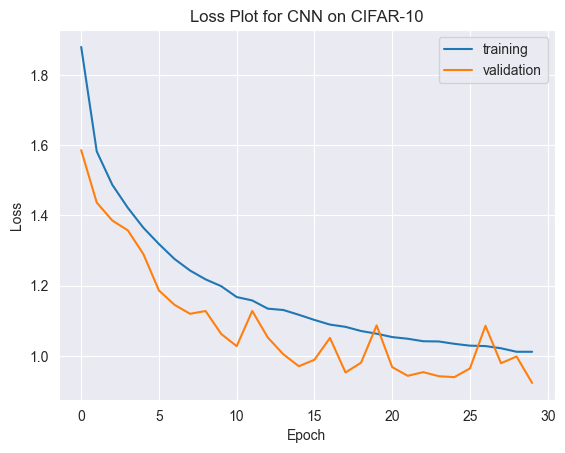

In [8]:
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Plot for CNN on CIFAR-10")
plt.legend()

In [9]:
# perform predictions over the test set
Y_test_predictions = np.argmax(model.predict(X_test), axis=1)

 65/313 [=====>........................] - ETA: 0s

2022-10-23 23:02:55.417175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step


[Text(0, 0.5, 'airplane'),
 Text(0, 1.5, 'automobile'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

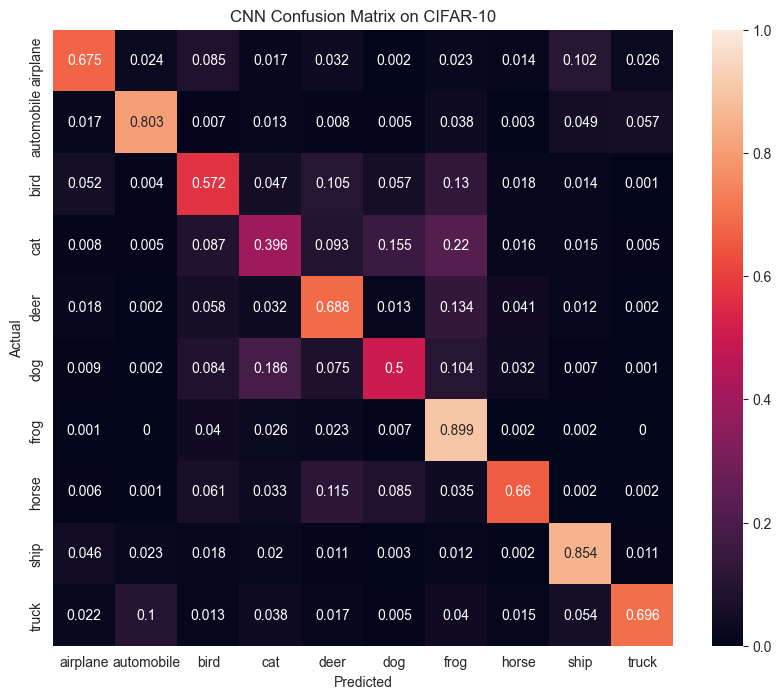

In [10]:
# build a confusion matrix for the test set
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')

plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.heatmap(cm, ax=ax, annot=True, fmt='g', vmin=0.0, vmax=1.0)

plt.title('CNN Confusion Matrix on CIFAR-10')
plt.xlabel('Predicted')
plt.ylabel('Actual')

ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

### Exploration

#### The network above has not been optimized. Some suggestions of things to try are below:
- Try swapping activation functions.
- Try adjusting the number of filters in the convolutional layers and the number of neurons in the dense layers.
- Try adding additional convolutional layers to the network. Remember to include a dropout layer after each learning layer.
- Try different batch sizes. Common choices are 8, 16, 32, 64, 128, 256, and 512
- Try different optimizers. Suggestions: Adam, RMSProp, standard SGD.
- The network has the tendency to overfit. Consider different regularization schemes to prevent overfitting and allow the network to learn for more epochs.
- Add an early stopping feature.